In [1]:
import networkx as nx
import matplotlib.pyplot as plt 
from IPython.display import SVG, display
import pygraphviz
# Note: to install pygraphviz on macOS, you need to first install graphviz using homebrew,
# and then tell pip to look for the graphviz headers and libraries in the homebrew directory:
#  brew install graphviz
#  python3 -m pip install \
#                --config-settings="--global-option=build_ext" \
#                --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
#                --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
#                pygraphviz

# TODO: move the SVG rendering to a git pre-commit hook so that people can change DOT files directly without needing
# to run this script to see the changes.

# README

## Figure 1

In [2]:
class BlockGraph:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.graph.add_node('source', label='start')
        self.graph.add_node('sink', label='end')
        self.source_node = 'source'
        self.sink_node = 'sink'

    def add_node(self, sequence):
        """
        Adds a node to the graph.

        Parameters:
        sequence (str): The sequence associated with a node. Note that in the actual gen code the sequence is hashed to save space.
        """
        node_id = self.graph.number_of_nodes() - 1 # Start node IDs at 1, not counting source and sink
        self.graph.add_node(node_id, sequence=sequence)
        return node_id
    
    def connect_to_source(self, node_id, to_pos=0):
        """
        Connects a node to the source node.

        Parameters:
        node_id (int): The ID of the node to connect to the source.
        to_pos (int): The position at which the edge arrives at node.
        """
        if to_pos == 0:
            # Connect to the caption instead of the first character
            to_pos = 'caption'

        self.graph.add_edge(self.source_node, node_id, to_pos=to_pos, rank='same', constraint=False)

    def connect_to_sink(self, node_id, from_pos=-1):
        """
        Connects a node to the sink node.

        Parameters:
        node_id (int): The ID of the node to connect to the sink.
        from_pos (int): The position from which the edge departs from the node.
        """
        if from_pos == -1:
            from_pos = len(self.graph.nodes[node_id]['sequence'])-1

        self.graph.add_edge(node_id, self.sink_node, from_pos=from_pos, rank='same', constraint=False)

    def add_edge(self, source, target):
        """
        Adds an edge to the graph with port information stored as edge attributes.

        Parameters:
        source (tuple): A tuple containing the source node and the position from which the edge departs.
        target (tuple): A tuple containing the target node and the position at which the edge arrives.
        """
        self.graph.add_edge(source[0], target[0], from_pos=source[1], to_pos=target[1])

    def highlight_ranges(self, node_id, highlight_ranges):
        """
        Highlights specific ranges in a node's sequence.

        Parameters:
        node_id (int): The ID of the node to apply highlights to.
        highlight_ranges (list): A list of tuples containing the start and end positions of the ranges to highlight.
        """
        sequence = self.graph.nodes[node_id]['sequence']
        highlights = [False] * len(sequence)
        for start, end in highlight_ranges:
            for i in range(start, end):
                highlights[i] = True
        self.graph.nodes[node_id]['highlights'] = highlights

    def render_graph(self, filename=None):
        # Create a copy of the graph to avoid modifying the original
        graph = self.graph.copy()

        for node in graph.nodes:
            if node in ['source', 'sink']:
                continue
            sequence = graph.nodes[node]['sequence']
            highlights = graph.nodes[node].get('highlights', [False] * len(sequence))
            formatted_sequence = [f'<B>{c}</B>' if highlights[i] else c for i, c in enumerate(sequence)]
            label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0'><TR>"
            label += f"<TD BORDER='0' PORT='caption'>{node}: </TD>"
            # Break up the sequence into nucleotides and port markers for graphviz
            label += '\n'.join(f"<TD PORT='{i}'><FONT FACE='Courier New'>{c}</FONT></TD>" for i, c in enumerate(formatted_sequence))
            label += "</TR></TABLE>>"

            graph.nodes[node]['shape'] = 'none'
            graph.nodes[node]['margin'] = 0
            graph.nodes[node]['label'] = label

        for edge in graph.edges:
            # Connect the head and tail of each edge to the correct port
            graph.edges[edge]['headport'] = f"{graph.edges[edge].get('to_pos','w')}"
            graph.edges[edge]['tailport'] = f"{graph.edges[edge].get('from_pos','e')}"

        # Convert the networkx graph to a pygraphviz graph
        graph = nx.nx_agraph.to_agraph(graph)

        # Draw the graph using pygraphviz
        graph.layout(prog='dot', args='-Grankdir=TD -Gsplines=true -Goverlap=scale')
        if filename:
            graph.write(f'{filename}.dot')
            graph.draw(f'{filename}.svg', prog='dot', format='svg')
            
        display(SVG(graph.draw(prog='dot', format='svg')))


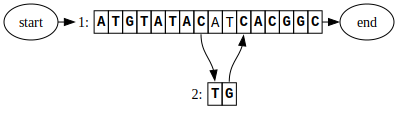

In [3]:
G = BlockGraph()

n1 = G.add_node('ATGTATACATCACGGC') # Derived from BBa_K1896001
n2 = G.add_node('TG')
G.connect_to_source(n1)
G.connect_to_sink(n1)
G.add_edge((n1, 7), (n2, 0))
G.add_edge((n2, 1), (n1, 10))
G.highlight_ranges(n1, [(0, 8), (10, 16)])
G.highlight_ranges(n1, [(0, 8), (10, 16)])
G.highlight_ranges(n2, [(0, 2)])

G.render_graph('figure_1')

## Figure 2

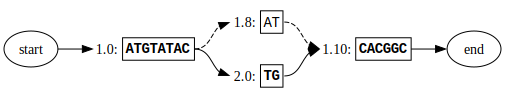

In [4]:
G = nx.DiGraph()
G.add_node('start')
G.add_node('end')
G.add_node('1.0', sequence='ATGTATAC', highlight=True)
G.add_node('1.8', sequence='AT')
G.add_node('2.0', sequence='TG', highlight=True)
G.add_node('1.10', sequence='CACGGC', highlight=True)

G.add_edge('start', '1.0')
G.add_edge('1.0', '1.8', style='dashed')
G.add_edge('1.0', '2.0')
G.add_edge('1.8', '1.10', style='dashed')
G.add_edge('2.0', '1.10')
G.add_edge('1.10', 'end')

for node in G.nodes:
    if node in ['start', 'end']:
        continue

    G.nodes[node]['shape'] = 'none'
    G.nodes[node]['margin'] = 0

    seq = G.nodes[node]['sequence']
    label = f"<<TABLE BORDER='0' CELLBORDER='1' CELLSPACING='0'><TR>"
    label += f"<TD BORDER='0' PORT='caption'>{node}: </TD>"
    if G.nodes[node].get('highlight', False):
        label += f"<TD><FONT FACE='Courier New'><B>{seq}</B></FONT></TD>"
    else:
        label += f"<TD><FONT FACE='Courier New'>{seq}</FONT></TD>"
    label += "</TR></TABLE>>"
    G.nodes[node]['label'] = label

for edge in G.edges:
    G.edges[edge]['headport'] = G.edges[edge].get('headport','w')
    G.edges[edge]['tailport'] = G.edges[edge].get('tailport','e')

# Convert the networkx graph to a pygraphviz graph
G = nx.nx_agraph.to_agraph(G)

# Draw the graph using pygraphviz
G.layout(prog='dot', args='-Grankdir=LR -Gsplines=true -Goverlap=scale')
G.write('figure_2.dot')
G.draw('figure_2.svg', prog='dot', format='svg')
    
display(SVG(G.draw(prog='dot', format='svg')))

